In [1]:
import sys, os
sys.path.append(os.path.abspath("/groups/sylvia/nawdex-hackathon/utilities/"))
sys.path.append(os.path.abspath("/groups/sylvia/nawdex-hackathon/shared/"))
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from domain_mean_utilities import *
from amip_like_utilities import *
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import warnings
import cartopy.crs as ccrs
warnings.filterwarnings("ignore")

In [2]:
import dict_nawdexsims
# simulations dictionary
simdict = dict_nawdexsims.simdictionary()
# dictionary for the days to be analyzed
anadaysdict = dict_nawdexsims.anadaysdictionary()

def colordictionary():
    # manually defined colors
    mymaroon= np.array([128,   0,   0])/255
    myred   = np.array([230,  25,  75])/255
    myorange= np.array([245, 130,  48])/255
    mymagenta=np.array([240, 50, 230 ])/255
    myolive = np.array([128, 128,   0])/255
    myteal  = np.array([  0, 128, 128])/255
    myblue  = np.array([  0, 130, 200])/255
    mynavy  = np.array([  0,   0, 128])/255

    return {'80' : mymaroon, '40' : myred, '20' : myorange, '10' : myolive, '5' : myteal, '2' : myblue}

farbe = colordictionary()

# Figure 1: Domain topography

In [4]:
# Domain topography map
file = '/groups/sylvia/nawdex-hackathon/domain-mean_data/extpar_icon-grid_nawdex_78w40e23n80n_R5000m_bitmap.nc'
dset = xr.open_dataset(str(file))
x, y = dset['lon'].values, dset['lat'].values

In [5]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """Truncate a colormap by specifying the start and endpoint."""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n}.{a:.2f},{b:.2f})'.format(n=cmap.name,a=minval,b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return(new_cmap)

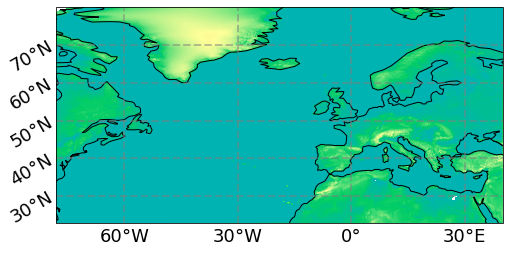

In [6]:
fs = 18
fig = plt.figure(figsize=(8,5.5))
ax = plt.axes(projection=ccrs.PlateCarree())
cmap = truncate_colormap(plt.get_cmap('terrain'), 0.2, 1.)
ax.tricontourf(x, y, dset['topography_c'], cmap=cmap, levels=np.arange(-10,8500,10))
ax.coastlines()
ax.set_extent([-78, 40, 23, 80],crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=np.linspace(-60,60,5),
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
#gl.xlocator = mticker.FixedLocator([-60, -30, 0, 30, 60])
#ax.xaxis.set_major_formattor(cartopy.mpl.ticker.LongitudeFormatter())
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fs}
gl.ylabel_style = {'size': fs, 'rotation': 30}

#fig.savefig('/groups/sylvia/nawdex-hackathon/figs/nawdex-domain-topography.png',bbox_inches='tight')
plt.show()

# Figure 3: Heating profiles from AMIP-like models over the North Atlantic

In [3]:
# load cloud-radiative heating and sea-land mask with external functions
ds_ico = icon_radheating()
ds_lmd = lmd_radheating()
# ds_mpi = mpi_radheating() # This function takes a while, like 10 minutes
ds_mpi = xr.open_dataset( '/groups/sylvia/nawdex-hackathon/globalmodels/crh_mpi.nc' )

In [4]:
ds_ico_zonalmean = make_zonalmean( ds_ico.mean('time') )
ds_lmd_zonalmean = make_zonalmean( ds_lmd )
ds_mpi_zonalmean = make_zonalmean( ds_mpi )

In [5]:
# time mean values for each model
ds_ico_nawdexmean_yearmean = make_nawdexmean(ds_ico.mean('time'))
ds_mpi_nawdexmean_yearmean = make_nawdexmean(ds_mpi)
ds_lmd_nawdexmean_yearmean = make_nawdexmean(ds_lmd)

# calculate the average over only the NAWDEX months - September and October
ds_ico_nawdexmean_seboctmean = make_nawdexmean(
    ds_ico.groupby('time.month').mean('time').sel(month=slice(9,10)).mean('month') )

In [6]:
# Generate a land-sea mask for calculations in the next cell
ds_lsm = xr.open_dataset( '/groups/sylvia/nawdex-hackathon/domain-mean_data/201609-land-sea-mask.nc' ).mean('time')
ds_ci = xr.open_mfdataset( '/groups/sylvia/nawdex-hackathon/domain-mean_data/seaice/ERA5_sea_ice*.nc' )

ds_merge_ci = []
jours = seldays()
for i in range( len(jours) ):
    ds_merge_ci.append( ds_ci.sel(time=jours[i]) )
    ds_ci_t = xr.concat( ds_merge_ci,dim='time' )

landmask = xr.merge([ds_lsm, ds_ci_t]).rename({'latitude': 'lat','longitude': 'lon'})
landmask = landmask.sel( lat=slice(71,32), lon=slice(-63,24) )

del ds_merge_ci
del ds_lsm
del ds_ci

In [30]:
bd = '/groups/sylvia/nawdex-hackathon/domain-mean_data/'
# Load the CloudSat profiles
CloudSat_profiles = xr.open_dataset( bd + 'cloudsat_calipso_global_3d_acre_multiyear_sept_oct_clim_0.25x0.25.nc' )
# selection of the domain of interest 
CloudSat_profiles2 = CloudSat_profiles.sel(lat=slice(32,71),lon=slice(-63,24)).mean('time')
# merge it with ERA5 land sea and ice fraction for filtering
CloudSat_out = xr.merge( [CloudSat_profiles2, landmask] )
# creating weights for domain-mean calculation
CloudSat_weights = np.cos(np.deg2rad(CloudSat_profiles2.lat))
# set weights to zero over land and areas with ice fraction
CloudSat_weights = CloudSat_weights * xr.where(CloudSat_out['lsm']+CloudSat_out['siconc'].max('time')<0.1, 1, 0) 
CloudSat_mean = CloudSat_profiles2.weighted(CloudSat_weights).mean(dim=['lat','lon'])

# Taking the CloudSat/CALIPSO pressure levels as in Sullivan & Voigt 2021

cs_dtlev = np.load('/groups/sylvia/nawdex-hackathon/domain-mean_data/cs_dtlev',allow_pickle=True)

ICON Sep+Oct min, max CRH: 
-0.2204741696246998 0.10907866250132948
ICON min, max CRH (full): 
-0.7852742291588576 0.44828842170792965
ICON min, max CRH (UT): 
-0.2660216357805061 0.12036370045498349
MPI min, max CRH (full): 
-0.36162071352845204 0.18297485874599032
MPI min, max CRH (UT): 
-0.3566271495106222 0.18297485874599032
LMD min, max CRH (full): 
-2.17429217746022 1.0335815565567201
LMD min, max CRH (UT): 
-1.1319149032124185 0.5101930854316089


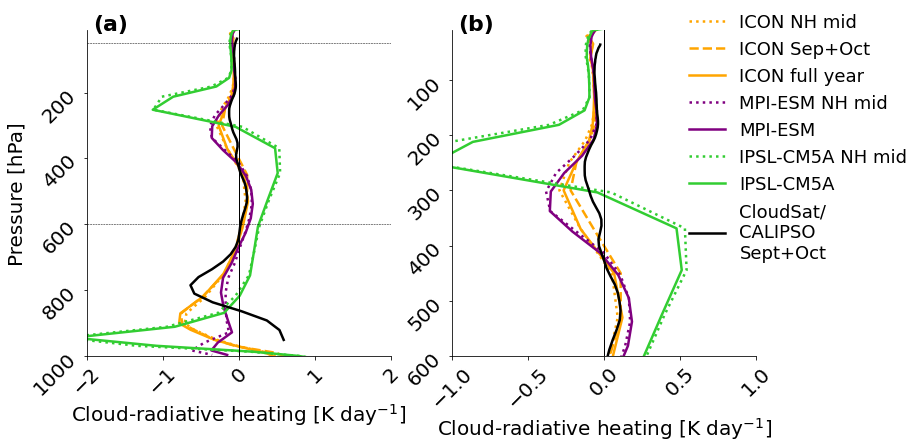

In [33]:
fs = 20
lw = 2.5
fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(12,6) )
for a in ax:
    a.plot(ds_ico_zonalmean['dtlwcld'], ds_ico_zonalmean.lev/100,
         color='orange', ls=':', lw=lw, label='ICON NH mid')
    a.plot(ds_ico_nawdexmean_seboctmean['dtlwcld'], ds_ico_nawdexmean_seboctmean.lev/100,
         color='orange', ls='--', lw=lw, label='ICON Sep+Oct')
    a.plot(ds_ico_nawdexmean_yearmean['dtlwcld'], ds_ico_nawdexmean_yearmean.lev/100,
         color='orange', lw=lw, label='ICON full year') #(0.88,0.3686,0)
    a.plot(ds_mpi_zonalmean['dtlwcld'], ds_mpi_zonalmean.lev/100,
         color='purple', ls=':', lw=lw, label='MPI-ESM NH mid')
    a.plot(ds_mpi_nawdexmean_yearmean['dtlwcld'], ds_mpi_nawdexmean_yearmean.lev/100,
         color='purple', lw=lw, label='MPI-ESM') #(0.8,0.4745, 0.6549)
    a.plot(ds_lmd_zonalmean['dtlwcld'], ds_lmd_zonalmean.lev/100,
           'limegreen', ls=':', lw=lw, label='IPSL-CM5A NH mid')
    a.plot(ds_lmd_nawdexmean_yearmean['dtlwcld'], ds_lmd_nawdexmean_yearmean.lev/100,
           'limegreen', lw=lw, label='IPSL-CM5A')
    a.plot(CloudSat_mean.acre_clim.values,cs_dtlev, #.isel(lev=slice(41,83))
         color='k',linewidth=lw,label='CloudSat/\nCALIPSO\nSept+Oct')
    a.set_xlabel( r'Cloud-radiative heating [K day$^{-1}$]', fontsize=fs )
    sexy_axes2( a, fs=fs )
    
# What are the minimum and maximum CRH values from the ICON Sep+Oct profile?
# Indices [5:25] correspond to the pressure levels shown in the Fig (600-10 hPa)
print('ICON Sep+Oct min, max CRH: ')
print(np.amin(ds_ico_nawdexmean_seboctmean['dtlwcld'][5:25]).values,
      np.amax(ds_ico_nawdexmean_seboctmean['dtlwcld'][5:25]).values)

# What are the minimum and maximum CRH values from the ICON profile?
print('ICON min, max CRH (full): ')
print(np.amin(ds_ico_nawdexmean_yearmean['dtlwcld']).values,
      np.amax(ds_ico_nawdexmean_yearmean['dtlwcld']).values)
print('ICON min, max CRH (UT): ')
print(np.amin(ds_ico_nawdexmean_yearmean['dtlwcld'][5:25]).values,
      np.amax(ds_ico_nawdexmean_yearmean['dtlwcld'][5:25]).values)

# What are the minimum and maximum CRH values from the MPI profile?
# Indices [11:36] correspond to the pressure levels shown in the Fig (600-10 hPa)
print('MPI min, max CRH (full): ')
print(np.amin(ds_mpi_nawdexmean_yearmean['dtlwcld']).values,
      np.amax(ds_mpi_nawdexmean_yearmean['dtlwcld']).values)
print('MPI min, max CRH (UT): ')
print(np.amin(ds_mpi_nawdexmean_yearmean['dtlwcld'][11:36]).values,
      np.amax(ds_mpi_nawdexmean_yearmean['dtlwcld'][11:36]).values)

# What are the minimum and maximum CRH values from the LMD profile?
# Indices [10:30] correspond to the pressure levels shown in the Fig (600-10 hPa)
print('LMD min, max CRH (full): ')
print(np.amin(ds_lmd_nawdexmean_yearmean['dtlwcld']).values,
      np.amax(ds_lmd_nawdexmean_yearmean['dtlwcld']).values)
print('LMD min, max CRH (UT): ')
print(np.amin(ds_lmd_nawdexmean_yearmean['dtlwcld'][10:30]).values,
      np.amax(ds_lmd_nawdexmean_yearmean['dtlwcld'][10:30]).values)

ax[0].plot([-2,2], [50,50], color='k', ls='--', lw=0.5)
ax[0].plot([-2,2], [600,600], color='k', ls='--', lw=0.5)
ax[0].set_ylim( 1000, 10 ); ax[0].set_xlim( -2, 2 )
ax[1].set_ylim( 600, 10 );  ax[1].set_xlim( -1, 1 )
ax[0].set_ylabel( 'Pressure [hPa]', fontsize=fs )
ax[0].text( 0.02, 1, '(a)', weight='bold', fontsize=fs+2, transform=ax[0].transAxes )
ax[1].text( 0.02, 1, '(b)', weight='bold', fontsize=fs+2, transform=ax[1].transAxes )
ax[1].legend(frameon=False,fontsize=fs-2,loc='upper right',bbox_to_anchor=((1.55,1.1)))

#fig.savefig('/groups/sylvia/nawdex-hackathon/figs/cloudradheating_nawdexmean_globalmodels.pdf',bbox_inches='tight')

# Figure 4: Heating profiles in the one- and two-moment schemes - 80 km

In [3]:
# sim_set_1 = radiative heating rates // sim_set_2 = temperature tendencies
sim_set_1 = []

for sim in list(simdict.keys()):
    
    path = '/groups/sylvia/nawdex-hackathon/domain-mean_data/radiative_heating_domain_mean/'
        
    ds = xr.open_dataset( path + 'atmradheating_fldmean_openocean_' + sim + '.nc' )
    
    # deriving cloud sw, lw and net radiative heating rates
    ds['lw_crh'] = ds['ddt_temp_radlw_fromflux'] - ds['ddt_temp_radlwclr_fromflux']
    ds['sw_crh'] = ds['ddt_temp_radsw_fromflux'] - ds['ddt_temp_radswclr_fromflux']
    ds['nt_crh'] = ds['lw_crh'] + ds['sw_crh']
        
    ds.attrs['simulation'] = sim    
     
    # Only the selected days 
    startday  = simdict[sim]['start']
    anadays = anadaysdict[startday]

    ds = ds.sel(time=slice(anadays[0], anadays[-1]))    
    sim_set_1.append(ds)
    
    del sim

In [4]:
sim_set_2 = []

for sim in list(simdict.keys()):
    
    path = '/groups/sylvia/nawdex-hackathon/domain-mean_data/temp_tendencies_domain_mean/'
        
    ds = xr.open_dataset(path+'3d_ddtemp_'+sim+'.nc')
    
    # net radiation temp_tendency
    ds['ddt_temp_rad'] = ds['ddt_temp_radlw'] + ds['ddt_temp_radsw']
        
    ds.attrs['simulation'] = sim
     
    # Only the selected days 
    startday  = simdict[sim]['start']
    anadays = anadaysdict[startday]

    ds = ds.sel(time=slice(anadays[0], anadays[-1]))    
    sim_set_2.append(ds)
    
    del sim

In [5]:
# select the datasets at 80 km resolution
crh_80_clim = time_merge_list(sim_set_1,'80km')
ddt_80_clim = time_merge_list(sim_set_2,'80km')

# adding them together
crh_ddt_80km = crh_80_clim + ddt_80_clim

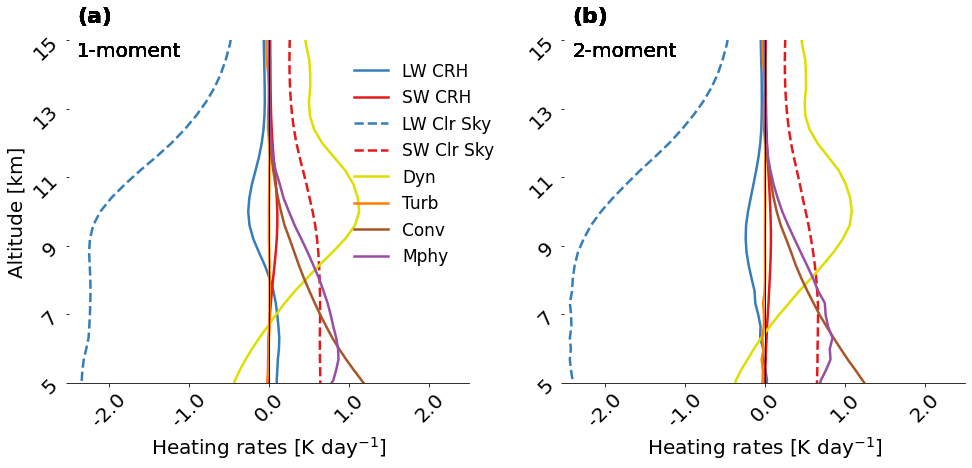

In [7]:
# 80 km resolution simulation averaged over 14 days
alltraces = []

fig = plt.figure(figsize=(14,7)) 
for var in ['lw_crh','sw_crh','ddt_temp_radlw','ddt_temp_radsw',
            'ddt_temp_dyn2','ddt_temp_turb','ddt_temp_pconv','ddt_temp_mphy']:
    
    elist = []
    for d in crh_ddt_80km:
        if var not in d.keys():
            continue
        elist.append( d[var].sel(height=slice(16,50)).mean('time').values )
    trace = np.mean( elist, axis=0 )
    alltraces.append( trace )
    
    plot_varmean(fig, crh_ddt_80km, var, fs=20, lw=2.5)
    
    #clim_hr_80
    
#plt.savefig('/groups/sylvia/nawdex-hackathon/figs/heatingrate-clim-80km-res.pdf', bbox_inches = 'tight', dpi=600)

In [14]:
# How close is the summation of these heating rates to zero?
print( np.nansum(alltraces, axis=0) )

# Pretty close

[ 2.24829470e-06  2.35931843e-06  1.92284027e-06  1.88399808e-06
  1.93967923e-06  1.60645369e-06  8.15860354e-07 -4.27924458e-07
 -1.62494158e-06 -2.36213178e-06 -2.41579119e-06 -2.23928811e-06
 -2.09648427e-06 -2.13279271e-06 -2.37788048e-06 -2.41624023e-06
 -2.33850232e-06 -2.11931716e-06 -1.90043091e-06 -1.63839249e-06
 -1.30381573e-06 -1.11184640e-06 -1.09528898e-06 -1.00743565e-06
 -8.95663039e-07 -9.95758973e-07 -1.01947068e-06 -1.34417566e-06
 -1.47978242e-06 -1.68238591e-06 -1.86531533e-06 -1.88579392e-06
 -2.28975283e-06 -2.60789810e-06 -3.15655151e-06]


# Figure 5: Net cloud-radiative heating with various model settings

In [8]:
# Load domain mean, open ocean radiative heating rates
sim_set_1 = []

for sim in list(simdict.keys()):
    
    path = '/groups/sylvia/nawdex-hackathon/domain-mean_data/radiative_heating_domain_mean/'
        
    ds = xr.open_dataset(path+'atmradheating_fldmean_openocean_'+sim+'.nc')
    
    # deriving cloud sw, lw and net radiative heating rates
    
    ds['lw_crh'] = ds['ddt_temp_radlw_fromflux'] - ds['ddt_temp_radlwclr_fromflux']
    ds['sw_crh'] = ds['ddt_temp_radsw_fromflux'] - ds['ddt_temp_radswclr_fromflux']
    ds['nt_crh'] = ds['lw_crh'] + ds['sw_crh']
        
    ds.attrs['simulation'] = sim    
     
    # Only the selected days 
    
    startday  = simdict[sim]['start']
    anadays = anadaysdict[startday]

    ds = ds.sel(time=slice(anadays[0], anadays[-1]))    
        
    sim_set_1.append(ds)
    
    del sim

In [9]:
# executing time_merge_list function and putting all simulations into a list 
list_climatology = []

for res in ['80km','40km','20km','10km','5km','2km']:
    list_climatology.append(time_merge_list(sim_set_1,res))
    
# change from tuple to list
c_list = list_climatology[0]+list_climatology[1]+list_climatology[2]+list_climatology[3]+list_climatology[4]+list_climatology[5]   
icon_list = list(c_list)   

In [10]:
# Generate a land-sea mask for calculations in the next cell
ds_lsm = xr.open_dataset( '/groups/sylvia/nawdex-hackathon/domain-mean_data/201609-land-sea-mask.nc' ).mean('time')
ds_ci = xr.open_mfdataset( '/groups/sylvia/nawdex-hackathon/domain-mean_data/seaice/ERA5_sea_ice*.nc' )

ds_merge_ci = []
jours = seldays()
for i in range( len(jours) ):
    ds_merge_ci.append( ds_ci.sel(time=jours[i]) )
    ds_ci_t = xr.concat( ds_merge_ci,dim='time' )

landmask = xr.merge([ds_lsm, ds_ci_t]).rename({'latitude': 'lat','longitude': 'lon'})
landmask = landmask.sel( lat=slice(71,32), lon=slice(-63,24) )

del ds_merge_ci
del ds_lsm
del ds_ci

In [11]:
# Load the ERA5 monthly mean CRH profiles
bd = '/groups/sylvia/nawdex-hackathon/domain-mean_data/'
ERA5_mean_sep = xr.open_dataset( bd + 'ERA5_mean_sep.nc' )
ERA5_mean_oct = xr.open_dataset( bd + 'ERA5_mean_oct.nc' )
ERA5_mean_all = xr.open_dataset( bd + 'ERA5_mean_all.nc' )

ERA5_mean_all.attrs['simulation'] = 'ERA5_all'
ERA5_mean_sep.attrs['simulation'] = 'ERA5_sep'
ERA5_mean_oct.attrs['simulation'] = 'ERA5_oct'

# Load the CloudSat profiles
CloudSat_profiles = xr.open_dataset( bd + 'cloudsat_calipso_global_3d_acre_multiyear_sept_oct_clim_0.25x0.25.nc' )
# selection of the domain of interest 
CloudSat_profiles2 = CloudSat_profiles.sel(lat=slice(32,71),lon=slice(-63,24)).mean('time')
# merge it with ERA5 land sea and ice fraction for filtering
CloudSat_out = xr.merge( [CloudSat_profiles2, landmask] )
# creating weights for domain-mean calculation
CloudSat_weights = np.cos(np.deg2rad(CloudSat_profiles2.lat))
# set weights to zero over land and areas with ice fraction
CloudSat_weights = CloudSat_weights * xr.where(CloudSat_out['lsm']+CloudSat_out['siconc'].max('time')<0.1, 1, 0) 
CloudSat_mean = CloudSat_profiles2.weighted(CloudSat_weights).mean(dim=['lat','lon'])

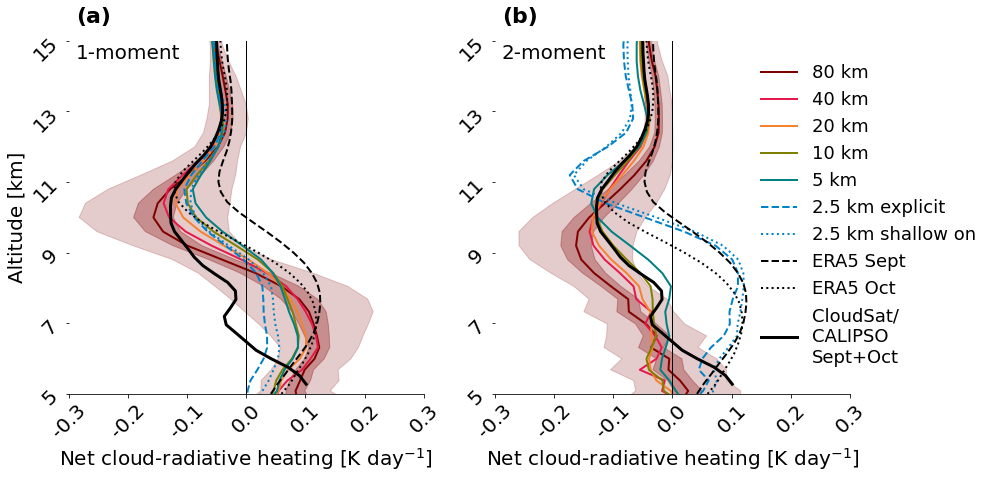

In [15]:
bottom_indx = 1 #15
top_indx = 60

# vertical profiles of ICON cloud-rad heating rates: all resolution and different microphysics
fig = plt.figure(figsize=(14, 6.5)) #18,12
gs = gridspec.GridSpec( 1, 2 )
ax0 = fig.add_subplot( gs[0,0] )
ax1 = fig.add_subplot( gs[0,1] )
#fig.tight_layout(pad = 2.5)
var = 'nt_crh'
zfull = get_fulllevel_height()

for ds, i in zip(icon_list, np.arange(14)):
    #print(i, ds.attrs['simulation'])
    pcolor, conv, mphys = process_sim( ds.attrs['simulation'] )
    
    # get linestyle according to convection scheme
    if conv==0:
        lstyle='--'
    elif conv==1:
        lstyle='-'
    elif conv==2:
        lstyle=':'

    #print(ds.attrs['simulation'],pcolor,lstyle)
        
    # This conditional filters only for the ICON simulations
    if ds.attrs['simulation'][0] == 'n':
        # average over 14 days climatology
        line = ds[var].sel(height=slice(bottom_indx+1,top_indx)).mean('time')
        dailymean = ds[var].sel(height=slice(bottom_indx+1,top_indx)).groupby('time.day').mean('time')
        std_height = np.std(dailymean, axis=0)
        ste_height = std_height/np.sqrt(np.size(dailymean['day']))

    if mphys == 1:
        #print( simdict[ds.attrs['simulation']], line[13:43].min()*86400 )
        ax0.plot( line.values*86400,zfull[0][bottom_indx:top_indx]/1e3, color=pcolor, linestyle=lstyle,
                         linewidth=2, label=simdict[ds.attrs['simulation']]['res'] )
                
        if simdict[ds.attrs["simulation"]]["res"]=="80km":
            ax0.fill_betweenx( y = zfull[0][bottom_indx:top_indx]/1e3, x1=(line-std_height)*86400,
                            x2=(line+std_height)*86400, color = pcolor, alpha=0.2 ) 
            ax0.fill_betweenx( y = zfull[0][bottom_indx:top_indx]/1e3, x1=(line-ste_height)*86400,
                            x2=(line+ste_height)*86400, color = pcolor, alpha=0.3 )
            
    if mphys == 2:
        if simdict[ds.attrs["simulation"]]["res"]=="2km":
            if conv == 0:
                lbl = '2.5 km explicit'
            else:
                lbl = '2.5 km shallow on'
        elif simdict[ds.attrs["simulation"]]["res"]=="5km":
            l = simdict[ds.attrs['simulation']]['res']
            lbl = l[:1] + ' km'
        else:
            l = simdict[ds.attrs['simulation']]['res']
            lbl = l[:2] + ' km'
            
        ax1.plot( line.values*86400,zfull[0][bottom_indx:top_indx]/1e3, color=pcolor, linestyle=lstyle,
                         linewidth=2, label=lbl )
                
        if simdict[ds.attrs["simulation"]]["res"]=="80km":
            ax1.fill_betweenx( y = zfull[0][bottom_indx:top_indx]/1e3, x1=(line-std_height)*86400,
                            x2=(line+std_height)*86400, color = pcolor, alpha=0.2 ) 
            ax1.fill_betweenx( y = zfull[0][bottom_indx:top_indx]/1e3, x1=(line-ste_height)*86400,
                            x2=(line+ste_height)*86400, color = pcolor, alpha=0.3 )

# Plot the ERA5 and CloudSat CRH profiles on both sets of axes
fs = 20
height = np.linspace(5, 15, 36)
for a in [ax0, ax1]:
    a.spines['bottom'].set_bounds(-0.3,0.3)
    a.set_xlim(-0.3,0.3)
    a.xaxis.set_ticks([-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3])
    a.xaxis.set_ticklabels([-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3], fontsize=fs)
    a.set_xlabel(r'Net cloud-radiative heating [K day$^{-1}$]',fontsize=fs)
    a.plot(ERA5_mean_sep.nt_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
         color='k',linewidth=2,linestyle='dashed',label='ERA5 Sept')
    a.plot(ERA5_mean_oct.nt_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
         color='k',linewidth=2,linestyle='dotted',label='ERA5 Oct')
    a.plot(CloudSat_mean.acre_clim.isel(lev=slice(41,83)).values,
           CloudSat_mean.lev.isel(lev=slice(41,83)).values/1000,
         color='k',linewidth=3,label='CloudSat/\nCALIPSO\nSept+Oct')

sexy_axes( ax1, fs )
sexy_axes( ax0, fs )
ax0.text(0.02,1.05,'(a)',weight='bold',fontsize=fs+2,transform=ax0.transAxes)
ax0.text(0.02,0.95,'1-moment',fontsize=fs,transform=ax0.transAxes)
ax1.text(0.02,1.05,'(b)',weight='bold',fontsize=fs+2,transform=ax1.transAxes)
ax1.text(0.02,0.95,'2-moment',fontsize=fs,transform=ax1.transAxes)
ax1.legend(loc='upper right',fontsize=fs-2,frameon=False,bbox_to_anchor=(1.4,0.98))
ax0.set_ylabel('Altitude [km]', fontsize=fs)

plt.show()
fig.savefig('/groups/sylvia/nawdex-hackathon/figs/netcrh-clim-all.pdf', bbox_inches = 'tight', dpi=600)

# Figure 6: LW and SW cloud-radiative heating with various model settings

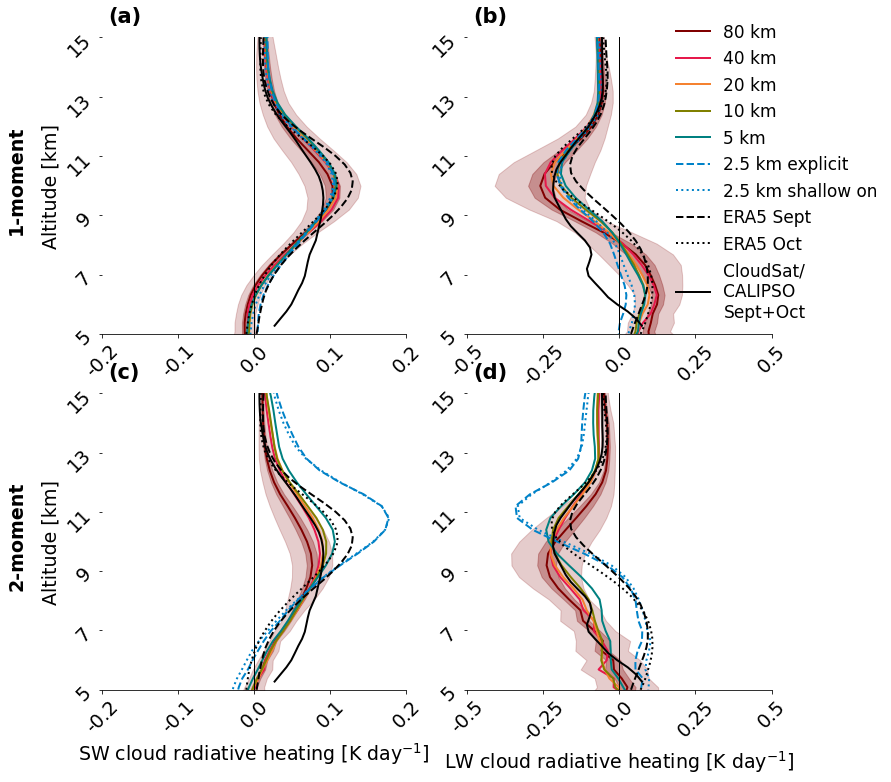

In [17]:
# vertical profiles of ICON cloud-rad heating rates: all resolution and different microphysics
fig, ax = plt.subplots( nrows=2, ncols=2, figsize=(12,12) )
var = [ 'lw_crh', 'sw_crh' ]
lims = [ [-0.2, 0.2], [-0.4, 0.4], [-0.2, 0.2], [-0.4, 0.4] ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
zfull = get_fulllevel_height()

for ds in icon_list:
    pcolor, conv, mphys = process_sim( ds.attrs['simulation'] )
    
    # get linestyle according to convection scheme
    if conv==0:
        lstyle='--'
    elif conv==1:
        lstyle='-'
    elif conv==2:
        lstyle=':'

    for v, i in zip(var, [1, 0]):
        # This conditional filters only for the ICON simulations
        if ds.attrs['simulation'][0] == 'n':
            # average over 14 days climatology
            line = ds[v].sel(height=slice(16,50)).mean('time')
            dailymean = ds[v].sel(height=slice(16,50)).groupby('time.day').mean('time')
            std_height = np.std(dailymean, axis=0)
            ste_height = std_height/np.sqrt(np.size(dailymean['day']))

        if mphys == 1:
            if simdict[ds.attrs["simulation"]]["res"]=="2km":
                if conv == 0:
                    lbl = '2.5 km explicit'
                else:
                    lbl = '2.5 km shallow on'
            elif simdict[ds.attrs["simulation"]]["res"]=="5km":
                l = simdict[ds.attrs['simulation']]['res']
                lbl = l[:1] + ' km'
            else:
                l = simdict[ds.attrs['simulation']]['res']
                lbl = l[:2] + ' km'
                
            ax[0,i].plot( line.values*86400,zfull[0][15:50]/1e3, color=pcolor, linestyle=lstyle,
                         linewidth=2, label=lbl )
                
            if simdict[ds.attrs["simulation"]]["res"]=="80km":
                ax[0,i].fill_betweenx( y = zfull[0][15:50]/1e3, x1=(line-std_height)*86400,
                            x2=(line+std_height)*86400, color = pcolor, alpha=0.2 ) 
                ax[0,i].fill_betweenx( y = zfull[0][15:50]/1e3, x1=(line-ste_height)*86400,
                            x2=(line+ste_height)*86400, color = pcolor, alpha=0.3 )
            
        if mphys == 2:
            if simdict[ds.attrs["simulation"]]["res"]=="2km":
                if conv == 0:
                    lbl = '2.5 km explicit'
                else:
                    lbl = '2.5 km shallow on'
            elif simdict[ds.attrs["simulation"]]["res"]=="5km":
                l = simdict[ds.attrs['simulation']]['res']
                lbl = l[:1] + ' km'
            else:
                l = simdict[ds.attrs['simulation']]['res']
                lbl = l[:2] + ' km'
            
            ax[1,i].plot( line.values*86400,zfull[0][15:50]/1e3, color=pcolor, linestyle=lstyle,
                         linewidth=2, label=lbl )
                
            if simdict[ds.attrs["simulation"]]["res"]=="80km":
                ax[1,i].fill_betweenx( y = zfull[0][15:50]/1e3, x1=(line-std_height)*86400,
                            x2=(line+std_height)*86400, color = pcolor, alpha=0.2 ) 
                ax[1,i].fill_betweenx( y = zfull[0][15:50]/1e3, x1=(line-ste_height)*86400,
                            x2=(line+ste_height)*86400, color = pcolor, alpha=0.3 )

# Plot the ERA5 and CloudSat CRH profiles on all axes
fs = 19
height = np.linspace(5, 15, 36)
lbl = [ '', '', 'SW cloud radiative heating [K day$^{-1}$]', 'LW cloud radiative heating [K day$^{-1}$]' ]
for a, l, i in zip(ax.flatten(), lbl, np.arange(4)):
    sexy_axes( a, fs=fs )
    a.set_xlabel( l, fontsize=fs )
    a.set_xlim( lims[i][0], lims[i][1] )
    a.text(0.02, 1.05, let[i], weight='bold', fontsize=fs+2, transform=a.transAxes)
    if i == 0 or i == 2:
        a.spines['bottom'].set_bounds(-0.2,0.2)
        a.set_xlim(-0.2,0.2)
        a.xaxis.set_ticks([-0.2,-0.1,0.0,0.1,0.2])
        a.xaxis.set_ticklabels([-0.2,-0.1,0.0,0.1,0.2], fontsize=fs)
        a.set_ylabel( 'Altitude [km]', fontsize=fs )
        a.plot(ERA5_mean_sep.sw_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
               color='k',linewidth=2,linestyle='dashed',label='ERA5 Sept')
        a.plot(ERA5_mean_oct.sw_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
                 color='k',linewidth=2,linestyle='dotted',label='ERA5 Oct')
        a.plot(CloudSat_mean.sw_acre_clim.isel(lev=slice(41,83)).values,
              CloudSat_mean.lev.isel(lev=slice(41,83)).values/1000,
              color='k',linewidth=2,label='CloudSat/\nCALIPSO\nSept+Oct')
    else:
        a.spines['bottom'].set_bounds(-0.5,0.5)
        a.set_xlim(-0.5,0.5)
        a.xaxis.set_ticks([-0.5,-0.25,0.0,0.25,0.5])
        a.xaxis.set_ticklabels([-0.5,-0.25,0.0,0.25,0.5], fontsize=fs)
        a.plot(ERA5_mean_sep.lw_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
               color='k',linewidth=2,linestyle='dashed',label='ERA5 Sept')
        a.plot(ERA5_mean_oct.lw_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
                 color='k',linewidth=2,linestyle='dotted',label='ERA5 Oct')
        a.plot(CloudSat_mean.lw_acre_clim.isel(lev=slice(41,83)).values,
              CloudSat_mean.lev.isel(lev=slice(41,83)).values/1000,
              color='k',linewidth=2,label='CloudSat/\nCALIPSO\nSept+Oct') 

fig.text(-0.28, 0.52, '1-moment', rotation='vertical', ha='center', va='center', weight='bold',
         fontsize=fs, transform=ax[0,0].transAxes)
fig.text(-0.28, 0.52, '2-moment', rotation='vertical', ha='center', va='center', weight='bold',
         fontsize=fs, transform=ax[1,0].transAxes)
#ax[0,0].text( 0.02, 0.95, '1-moment', fontsize=fs, transform=ax[0,0].transAxes )
#ax[1,1].text( 0.02, 0.95, '2-moment', fontsize=fs, transform=ax[0,1].transAxes )
ax[0,1].legend( fontsize=fs-2, frameon=False, loc='upper right', bbox_to_anchor=(1.4,1.1) )

plt.show()
fig.savefig('/groups/sylvia/nawdex-hackathon/figs/lwswcrh-clim-all.pdf', bbox_inches = 'tight', dpi=600)

# Figure 7: Box plots of cloud class occurrence

In [5]:
# Save the occurrence dataframe in a pickle (or load it).
import pickle5 as pickle
file = '/groups/sylvia/nawdex-hackathon/occurrence_data/cloud_class_occurrence_area_weighting_mp2.pkl'
with open(file, "rb") as fh:
      A_df = pickle.load(fh)

A_df['Cloud class'].replace( {'HI': 'High', 'MED': 'Middle', 'LO': 'Low', 'H-M': 'High-x-Middle', 'M-L': 'Middle-x-Low',
                             'H-L': 'High-Low', 'H-M-L': 'High-x-Middle-x-Low'},
                            inplace=True )
A_df['Resolution'].replace( {'80km': '80', '40km': '40', '20km': '20', '10km': '10', '5km': '5', '2km': '2'},
                            inplace=True )

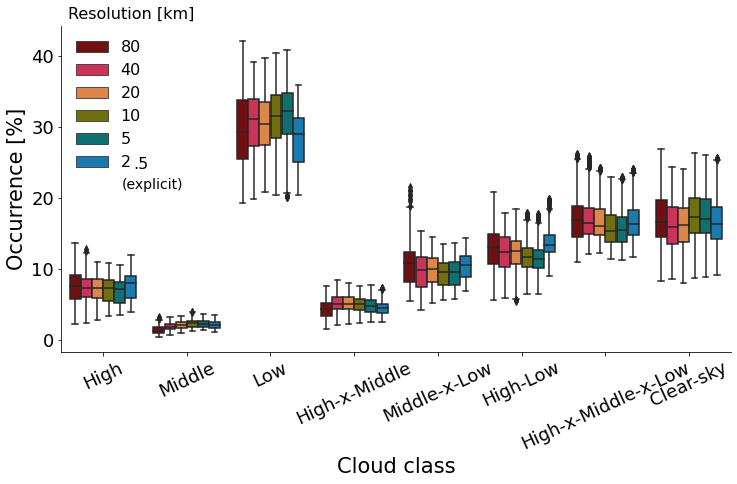

In [7]:
fs = 18
resolutions = ['80','40','20','10','5','2']

# Plot the spatiotemporal probability distribution of the different classes for a threshold of 10%.
fig = plt.figure( figsize=(12,6) )
ax = sns.boxplot( x='Cloud class', y='Occurrence_thr1', hue='Resolution', data=A_df, hue_order=resolutions, palette=farbe )
ax.set_xticklabels( ax.get_xticklabels(), rotation=25, fontsize=fs )
ax.tick_params( axis="y", labelsize=fs )
ax.set_ylabel( 'Occurrence [%]', fontsize=fs+3 )
ax.set_xlabel( 'Cloud class', fontsize=fs+3 )
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.legend( frameon=False, fontsize=fs-2 )
ax.text( 0.01, 1.02, 'Resolution [km]', fontsize=fs-2, transform=ax.transAxes )
ax.text( 0.107, 0.56, '.5', fontsize=fs-2, transform=ax.transAxes )
ax.text( 0.09, 0.5, '(explicit)', fontsize=fs-4, transform=ax.transAxes )

fig.savefig('/groups/sylvia/nawdex-hackathon/figs/cloudclass_occurrence_mp2.pdf', bbox_inches='tight')

# Figure 8: Net cloud-radiative heating for various cloud classes

In [19]:
# thresholds for cloud classes
# 'hq62_mq67_lq30', 'hq60_mq60_lq25', 'hq65_mq70_lq35'
threshold = 'hq62_mq67_lq30'
ipath = '/groups/sylvia/nawdex-hackathon/cloudclass_data/' + \
        'cloudheating_for_cloudclass/' + threshold + '/'

# simulation setups
resolutions = ['80km', '40km', '20km', '10km', '5km', '2km', '2km-shcon']
mphysics = [1, 2]
#conv = 1

# cloud classes
ncclass = 8 # number of cloud classes
cclasses = ['High', 'Middle', 'Low',
            'High-x-Middle', 'Middle-x-Low', 'High-Low', 'High-x-Middle-x-Low', 'Clear Sky']
cclass_save = ['H', 'M', 'L', 'H-x-M', 'M-x-L', 'H-L', 'H-x-M-x-L', 'clearsky']

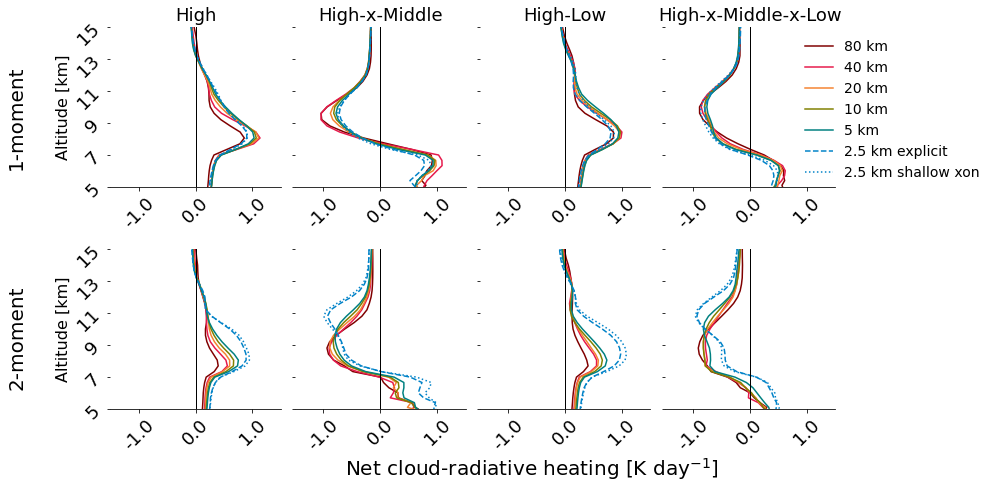

In [23]:
# Overview plot
# all classes, all heights, both microphysics schemes in one figure
#varlist = ['chr_lw', 'chr_sw', 'chr_net']
fs = 20
var = 'chr_net'
zfull = get_fulllevel_height()

# open figure, add lines with each iteration over the resolutions and cloud classes
fig, ax = plt.subplots(2, 4, figsize=(13, 6.5), sharey=True)  # 4-->8
for mphys in mphysics:
    for res in resolutions:
        if res in ['80km', '40km', '20km', '10km', '5km']:
            conv = 1
            lstyle='-'
        elif res == '2km':
            conv = 0
            lstyle = '--'
        elif res == '2km-shcon':
            conv = 2
            lstyle = ':'
            res = '2km'

        # get all expids for simulations with same configuration
        expids = [key for key in simdict if simdict[key]['res'] == res and \
                                            simdict[key]['conv'] == conv and \
                                            simdict[key]['mphys'] == mphys]

        # read cloud cover from all simulations that have the same
        # configuration
        data = []
        for expid in expids:
            if var == 'chr_net':
                ds = xr.open_dataset(ipath + expid + \
                                    '_cloudheatingrate_cloudclasses_' + \
                                    'areamean_timemean_oceanmask_applied_' + \
                                    threshold + '.nc')
                for c in range(1, ncclass+1):
                    da = ds['chr_lw_cclass' + str(c)] + ds['chr_sw_cclass' + str(c)]
                    da.name = "chr_net_cclass" + str(c)
                    if c == 1:
                        ds_chr = da.to_dataset()
                    else:
                        ds_chr = ds_chr.update(da.to_dataset())
                    del da
                del c
            else:
                ds_chr = xr.open_dataset(ipath + expid + \
                                            '_cloudheatingrate_cloudclasses_' + \
                                            'areamean_timemean_oceanmask_applied_' + \
                                            threshold + '.nc')
            data.append(ds_chr)
            del ds_chr

        # merge data with same configuration and get mean over simulations
        ds = xr.concat([x for x in data], 'nsim')
        ds = ds.mean('nsim')

        del data, expid

        # plot cloud cover for different cloud classes
        for i, c in enumerate([0, 3, 5, 6]): #range(ncclass):
            if res=="2km":
                if conv == 0:
                    lbl = '2.5 km explicit'
                else:
                    lbl = '2.5 km shallow xon'
            elif res=="5km":
                lbl = res[:1] + ' km'
            else:
                lbl = res[:2] + ' km'
                
            ax[mphys-1, i].plot(ds[var + '_cclass' + str(c+1)]*86400, zfull[0]/1000,
                                color=colordict[res], linestyle=lstyle, label=lbl)
            ax[mphys-1, i].tick_params(labelsize=fs-2)
            ax[mphys-1, i].spines['right'].set_color('none')
            ax[mphys-1, i].spines['top'].set_color('none')
            ax[mphys-1, i].spines['left'].set_color('none')
            #ax[mphys-1, i].spines['left'].set_position('zero')
            ax[mphys-1, i].axvline(0, linewidth=1, color='k')
            ax[mphys-1, i].set_yticks(np.arange(1, 31, 2))
            ax[mphys-1, i].set_ylim(5, 15)
            if ax[mphys-1, i].get_ylim() == (0.0, 17.0):
                ax[mphys-1, i].axhline(5, linewidth=1, color='k')
                ax[mphys-1, i].axhline(15, linewidth=1, color='k')
            
            ax[mphys-1, i].set_xticks(np.arange(-2, 3.5, 1))
            ax[mphys-1, i].set_xlim(-1.5, 1.5)
            ax[0, i].set_title(cclasses[c], fontsize=fs-2)
            ax[mphys-1,i].set_xticklabels( ax[mphys-1,i].get_xticks(), rotation=45 )
            ax[mphys-1,i].set_yticklabels( ax[mphys-1,i].get_yticks(), rotation=45 )

ax[0,3].legend( frameon=False, fontsize=fs-6, bbox_to_anchor=(0.75,1.0) )
fig.tight_layout()

# legend: text for lines
#xloc = [0.18, 0.41, 0.55, 0.18, 0.41, 0.55, 0.7]
#xloc = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
#for r, res in enumerate(resolutions[:-1]):
#    if resolutions[r] == '2km':
#        fig.text(xloc[r], -0.08, '2.5km', color=colordict[res],
#                ha='left', va='center', rotation='horizontal', fontsize=fs,
#                backgroundcolor='white')
#    else:
#        fig.text(xloc[r], -0.08, resolutions[r], color=colordict[res],
#                ha='left', va='center', rotation='horizontal', fontsize=fs,
#                backgroundcolor='white')
#del r, res, xloc

#leg = ax[.legend(ncol=1, prop={'size':15})
##leg.get_frame().set_linewidth(0.0)
##del leg

ax[0, 0].set_ylabel('Altitude [km]', fontsize=16)
ax[1, 0].set_ylabel('Altitude [km]', fontsize=16)
#fig.text(-0.02, 0.5, 'Height [km]', rotation='vertical',
#         ha='center', va='center', fontsize=16)

fig.text(0.5, -0.01, r'Net cloud-radiative heating [K day$^{-1}$]',
         rotation='horizontal', ha='center', va='center', fontsize=fs)
fig.text(-0.05, 0.74, '1-moment',
         rotation='vertical', ha='center', va='center', fontsize=fs)
fig.text(-0.05, 0.27, '2-moment',
        rotation='vertical', ha='center', va='center', fontsize=fs)
        
plt.show(fig)
fig.savefig('/groups/sylvia/nawdex-hackathon/figs/netcrh_cloudclass.pdf', bbox_inches = 'tight', dpi=600)

# Figure 9: Cloud properties at different resolutions

In [26]:
sim_set_new1 = []

for sim in list(simdict.keys()):
    path = '/groups/sylvia/nawdex-hackathon/clc-qc-qi_data/'
    
    if simdict[sim]['start'] == '20160922':
        
        ds = xr.open_dataset(path+'3dcloud_'+sim+'.nc')
        ds['tot_qc_dia'] = ds['tot_qc_dia']*1e6
        ds['tot_qi_dia'] = ds['tot_qi_dia']*1e6

        ds.attrs['simulation'] = sim

        sim_set_new1.append(ds)
        del sim 
    
sim_set_new = []
for i in range(len(sim_set_new1)):
    test = select_analysis_days(sim_set_new1[i], sim_set_new1[i].attrs['simulation'])
    sim_set_new.append(test)

# get height values for y-axis
data = xr.open_dataset( '/groups/sylvia/nawdex-hackathon/domain-mean_data/nawdexnwp-80km-mis-0001_2016092200_fg_DOM01_ML_0036.nc' )
data['z_ifc'] = data['z_ifc'].diff('height_3', label='lower') / 2 + data['z_ifc'][:-1,:]
data['z_ifc'] = data['z_ifc'].rename( {'height_3': 'height'} )
height=data['z_ifc'].isel( ncells_2=0 )

In [29]:
def plot_thmean( _ds_icon_list, _var, num ):
    ax = fig.add_subplot( 2, 3, num )
    fs = 20
    let = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
    for ds in _ds_icon_list:
        if (simdict[ds.attrs['simulation']]['conv'] == 0) & (simdict[ds.attrs['simulation']]['res'] != '2km'):
            continue
        if (simdict[ds.attrs['simulation']]['res'] == '2km') & (simdict[ds.attrs['simulation']]['conv'] == 1):
            continue
    
        pcolor = colordict[simdict[ds.attrs['simulation']]['res']]
        # get linestyle according to convection scheme
        conv = simdict[ds.attrs['simulation']]['conv']
        if conv==0:
            lstyle='--'
        elif conv==1:
            lstyle='-'
        elif conv==2:
            lstyle=':'
        mphys = simdict[ds.attrs['simulation']]['mphys']
        
        if mphys == 1:
            ax = fig.add_subplot( 2, 3, num )
            line = ds[_var].mean( 'time' )
            if simdict[ds.attrs['simulation']]['res'] == '2km' and conv==1:
                continue
            elif simdict[ds.attrs['simulation']]['res'] == '2km' and conv==0:
                lbl = '2.5 km explicit'
            elif simdict[ds.attrs['simulation']]['res'] == '2km' and conv==2:
                lbl = '2.5 km shallow on'
            elif simdict[ds.attrs['simulation']]['res'] == '5km':
                lbl = simdict[ds.attrs['simulation']]['res'][:1] + ' km'
            else:
                lbl = simdict[ds.attrs['simulation']]['res'][:2] + ' km'
            ax.plot( line.values, height/1e3, color=pcolor, linestyle=lstyle, linewidth=1.8,
                     label=lbl)
            ax.tick_params( labelsize=fs )
            ax.spines['left'].set_bounds( 5, 15 )
            ax.axes.xaxis.set_ticklabels( [] )
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.yaxis.set_ticks( [5, 7, 9, 11, 13, 15] )
            ax.set_ylim( 5, 15 )
            ax.text( 0.02, 1.02, let[num-1], fontsize=fs+3, transform=ax.transAxes )
            
            if num == 1:
                ax.set_xlim( 0, 6 )
                ax.xaxis.set_ticks([0, 2, 4, 6])
                ax.xaxis.set_ticklabels( [0, 2, 4, 6], rotation=45 )
                ax.yaxis.set_ticklabels( [5, 7, 9, 11, 13, 15], fontsize=fs, rotation=45 )
                ax.legend( fontsize=fs-3, frameon=False, loc='upper right' )
                ax.set_ylabel( "Altitude [km]", fontsize=fs )
                ax.text( -0.35, 0.5, '1-moment', rotation='vertical', ha='center', va='center', fontsize=fs,
                         transform=ax.transAxes )
            if num == 2 or num == 3:
                ax.set_xlim( 0, 20.1 )
                ax.xaxis.set_ticks( [0, 5, 10, 15, 20] )
                ax.xaxis.set_ticklabels( [0, 5, 10, 15, 20], rotation=45 )
                ax.yaxis.set_ticklabels( [] )
            
        elif mphys == 2:
            ax = fig.add_subplot( 2, 3, num+3 )
            line = ds[_var].mean('time')
            #if num == 2:
            #    print( simdict[ds.attrs['simulation']], line[13:43].max() )
            ax.plot( line.values,height/1e3, color=pcolor, linestyle=lstyle, linewidth=1.8,
                     label=simdict[ds.attrs['simulation']]['res'])
            ax.spines['left'].set_bounds( 5, 15 )
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.yaxis.set_ticks( [5, 7, 9, 11, 13, 15] )
            ax.yaxis.set_ticklabels( [5, 7, 9, 11, 13, 15], fontsize=fs, rotation=45 )
            ax.set_ylim( 5, 15 )
            ax.tick_params( axis='x', labelsize=fs, rotation=45 )
            ax.text( 0.02, 1.02, let[num+2], fontsize=fs+3, transform=ax.transAxes )
            
            if num+3 == 4:
                ax.spines['bottom'].set_bounds( 0, 6 )
                ax.set_xlim( 0, 6 )
                ax.set_xlabel( 'Cloud water [mg kg$^{-1}$]', fontsize=fs )
                ax.set_ylabel( "Altitude [km]", fontsize=fs )
                ax.text( -0.35, 0.5, '2-moment', rotation='vertical', ha='center', va='center', fontsize=fs,
                         transform=ax.transAxes )
            if num+3 == 5:
                print( simdict[ds.attrs['simulation']]['res'] )
                i = np.argmax( line.values )
                print( height[i] )
                ax.spines['bottom'].set_bounds( 0, 20.1 )
                ax.set_xlim( 0, 20.1 )
                ax.xaxis.set_ticks( [0, 5, 10, 15, 20] )
                ax.xaxis.set_ticklabels( [0, 5, 10, 15, 20] )
                ax.yaxis.set_ticklabels( [] )
                ax.set_xlabel( 'Cloud fraction [%]', fontsize=fs )
            if num+3 == 6:
                ax.spines['bottom'].set_bounds( 0, 20 )
                ax.set_xlim( 0, 20 )
                ax.xaxis.set_ticks( [0, 5, 10, 15, 20] )
                ax.xaxis.set_ticklabels( [0, 5, 10, 15, 20] )
                ax.yaxis.set_ticklabels( [] )
                ax.set_xlabel( 'Cloud ice [mg kg$^{-1}$]', fontsize=fs )

80km
<xarray.DataArray 'z_ifc' ()>
array(9194.35, dtype=float32)
Coordinates:
    height   float64 33.0
40km
<xarray.DataArray 'z_ifc' ()>
array(8801.577, dtype=float32)
Coordinates:
    height   float64 34.0
20km
<xarray.DataArray 'z_ifc' ()>
array(8418.459, dtype=float32)
Coordinates:
    height   float64 35.0
10km
<xarray.DataArray 'z_ifc' ()>
array(8418.459, dtype=float32)
Coordinates:
    height   float64 35.0
5km
<xarray.DataArray 'z_ifc' ()>
array(8418.459, dtype=float32)
Coordinates:
    height   float64 35.0
2km
<xarray.DataArray 'z_ifc' ()>
array(8801.577, dtype=float32)
Coordinates:
    height   float64 34.0
2km
<xarray.DataArray 'z_ifc' ()>
array(8801.577, dtype=float32)
Coordinates:
    height   float64 34.0


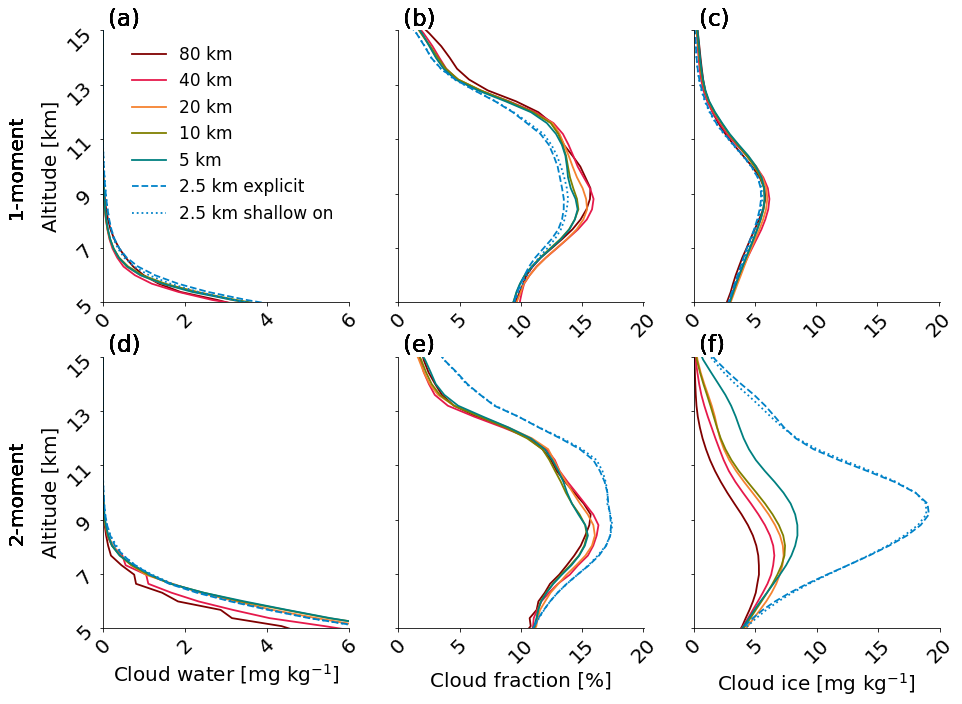

In [30]:
fig = plt.figure( figsize=(15,11) )
ax = fig
for i, var in enumerate( ['tot_qc_dia','clc','tot_qi_dia'] ):
    plot_thmean( sim_set_new, var, i+1 )
    
plt.savefig( '/groups/sylvia/nawdex-hackathon/figs/qc-qi-clc_profiles.pdf', bbox_inches = 'tight', dpi=600 )

# Figure 10: Cloud ice profiles for various cloud classes

In [31]:
# all classes, all heights, both microphysics schemes in one figure
fs = 20
mphysics = [1, 2]
var = 'tot_qi_dia'
threshold = 'hq62_mq67_lq30'
ipath = '/groups/sylvia/nawdex-hackathon/cloudclass_data/' + \
        'cloudprops_for_cloudclass/' + threshold + '/'
resolutions = ['80km', '40km', '20km', '10km', '5km', '2km', '2km-shcon']

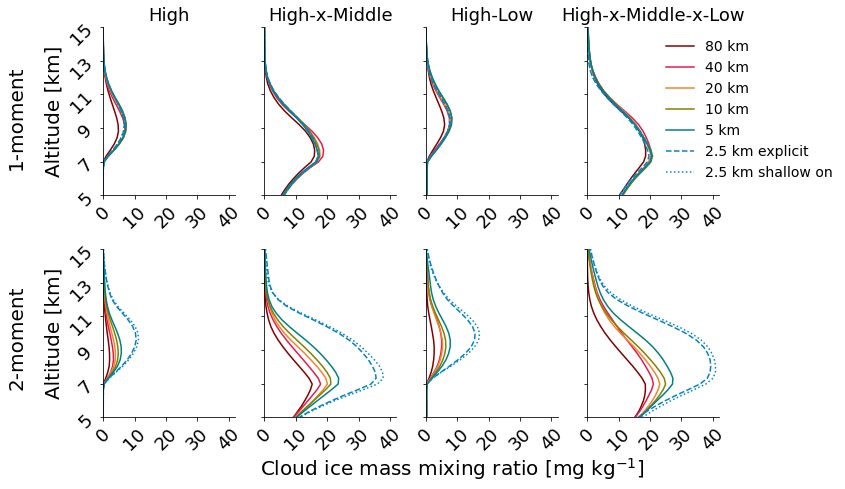

In [32]:
# open figure, add lines with each iteration over the resolutions
# and cloud classes
zfull = get_fulllevel_height()
fig, ax = plt.subplots(2, 4, figsize=(11, 6.5), sharey=True)
for mphys in mphysics:
    for res in resolutions:
        if res in ['80km', '40km', '20km', '10km', '5km']:
            conv = 1
            lstyle='-'
        elif res == '2km':
            conv = 0
            lstyle = '--'
        elif res == '2km-shcon':
            conv = 2
            lstyle = ':'
            res = '2km'

        # get all expids for simulations with same configuration
        expids = [key for key in simdict if simdict[key]['res'] == res and \
                                            simdict[key]['conv'] == conv and \
                                            simdict[key]['mphys'] == mphys]

        # read cloud cover from all simulations that have the same
        # configuration
        data = []
        for expid in expids:
            ds = xr.open_dataset(ipath + expid + \
                                '_cloudproperties_cloudclasses_' + \
                                'areamean_timemean_oceanmask_applied_' + \
                                threshold + '.nc')
            data.append(ds)
        del ds

        # merge data with same configuration and get mean over simulations
        ds = xr.concat([x for x in data], 'nsim')
        ds = ds.mean('nsim')
        del data, expid

        for i, c in enumerate([0, 3, 5, 6]): #range(ncclass):
            if res == '2km' and conv == 0:
                lbl = '2.5 km explicit'
            elif res == '2km' and conv == 2:
                lbl = '2.5 km shallow on'
            elif res == '5km':
                lbl = res[:1] + ' km'
            else:
                lbl = res[:2] + ' km'
                
            ax[mphys-1, i].plot(ds[var + '_cclass' + str(c+1)]*10**6, zfull[0]/1000,
                            color=colordict[res], linestyle=lstyle, label=lbl)
            ax[mphys-1, i].tick_params(labelsize=fs-2, rotation=45)
            ax[mphys-1, i].spines['right'].set_color('none')
            ax[mphys-1, i].spines['top'].set_color('none')
            #ax[c].spines['left'].set_position('zero')
            ax[mphys-1, i].set_yticks(np.arange(1, 31, 2))
            ax[mphys-1, i].set_ylim(5, 15) #(5, 15)#(0, 17)
            #if ax[mphys-1, c].get_ylim() == (0.0, 17.0):
            #ax[mphys-1, i].axhline(5, linewidth=1, color='k')
            #ax[mphys-1, i].axhline(15, linewidth=1, color='k')
            #ax[mphys-1, i].ticklabel_format(axis='x', scilimits=(-2,-2))
            ax[mphys-1, i].set_xticks([0, 10, 20, 30, 40])
            ax[mphys-1, i].set_xlim(0, 42)
            ax[0, i].set_title(cclasses[c], fontsize=fs-2)
        del c
        del ds
    del res
del mphys

ax[0,3].legend( frameon=False, fontsize=fs-6, bbox_to_anchor=(0.5,1.0) )
fig.tight_layout()

# legend: text for lines
#xloc = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
#for r, res in enumerate(resolutions[:-1]):
#    if resolutions[r] == '2km':
#        fig.text(xloc[r], -0.08, '2.5km', color=colordict[res],
#                ha='left', va='center', rotation='horizontal', fontsize=fs,
#                backgroundcolor='white')
#    else:
#        fig.text(xloc[r], -0.08, resolutions[r], color=colordict[res],
#                ha='left', va='center', rotation='horizontal', fontsize=fs,
#                backgroundcolor='white')
#del r, res, xloc

ax[0, 0].set_ylabel('Altitude [km]', fontsize=fs)
ax[1, 0].set_ylabel('Altitude [km]', fontsize=fs)
fig.text(0.5, -0.01, 'Cloud ice mass mixing ratio [mg kg$^{-1}$]',
            rotation='horizontal', ha='center', va='center', fontsize=fs)
fig.text(-0.05, 0.74, '1-moment',
            rotation='vertical', ha='center', va='center', fontsize=fs)
fig.text(-0.05, 0.27, '2-moment',
            rotation='vertical', ha='center', va='center', fontsize=fs)
        
plt.show(fig)
fig.savefig('/groups/sylvia/nawdex-hackathon/figs/qi_dia_cloudclass.pdf', bbox_inches = 'tight', dpi=600)

# Figure 11: Ice number and snow profiles for various cloud classes

In [33]:
# all classes, all heights, both microphysics schemes in one figure
fs = 20
var = ['qs', 'qni']
mphys = [ 1, 2 ]
vardir = [  'qs_qr_for_cloudclass/', 'qg_qnx_for_cloudclass/' ]
prefix = [ '_qs_qr', '_qg_qnx' ]
threshold = 'hq62_mq67_lq30'
ipath = [ '/groups/sylvia/nawdex-hackathon/cloudclass_data/' + i + '/' for i in vardir ]
resolutions = ['80km', '40km', '20km', '10km', '5km', '2km', '2km-shcon']
cclasses = ['High', 'Middle', 'Low',
            'High-x-Middle', 'Middle-x-Low', 'High-Low', 'High-x-Middle-x-Low', 'Clear Sky']
cclass_save = ['H', 'M', 'L', 'H-x-M', 'M-x-L', 'H-L', 'H-x-M-x-L', 'clearsky']
zfull = get_fulllevel_height()

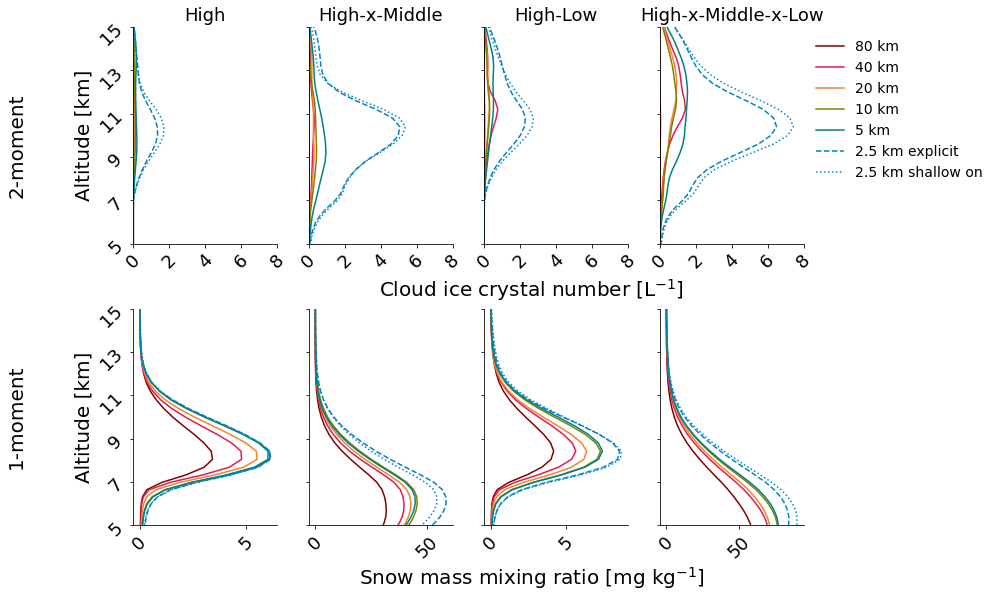

In [34]:
# open figure, add lines with each iteration over the resolutions
# and cloud classes
fig, ax = plt.subplots(2, 4, figsize=(13, 8), sharey=True)
for v, vdir, p, m in zip(var, ipath, prefix, mphys):
    for res in resolutions:
        if res in ['80km', '40km', '20km', '10km', '5km']:
            conv = 1
            lstyle='-'
        elif res == '2km':
            conv = 0
            lstyle = '--'
        elif res == '2km-shcon':
            conv = 2
            lstyle = ':'
            res = '2km'

        # get all expids for simulations with same configuration
        expids = [key for key in simdict if simdict[key]['res'] == res and \
                                            simdict[key]['conv'] == conv and \
                                            simdict[key]['mphys'] == m]
        
        # read cloud cover from all simulations that have the same
        # configuration
        data = []
        for expid in expids:
            ds = xr.open_dataset(vdir + expid + p + '_cloudclasses_' + \
                                'areamean_timemean_oceanmask_applied_' + \
                                threshold + '.nc')
            data.append(ds)
        del ds

        # merge data with same configuration and get mean over simulations
        ds = xr.concat([x for x in data], 'nsim')
        ds = ds.mean('nsim')
        del data, expid

        for i, c in enumerate([0, 3, 5, 6]):
            if res == '2km' and conv == 0:
                lbl = '2.5 km explicit'
            elif res == '2km' and conv == 2:
                lbl = '2.5 km shallow on'
            elif res == '5km':
                lbl = res[:1] + ' km'
            else:
                lbl = res[:2] + ' km'
                
            ax[m-1, i].tick_params(labelsize=fs-2, rotation=45)
            ax[m-1, i].spines['right'].set_color('none')
            ax[m-1, i].spines['top'].set_color('none')
            ax[m-1, i].set_yticks(np.arange(1, 31, 2))
            ax[m-1, i].set_ylim(5, 15)
            ax[0, i].set_title(cclasses[c], fontsize=fs-2)
            if v == 'qni':
                ax[0, i].plot(ds[v + '_cclass' + str(c+1)]/10**6, zfull[0]/1000,
                            color=colordict[res], linestyle=lstyle, label=lbl)
                ax[0, i].set_xlim( [0, 8] )
                ax[0, i].set_xticks( [0, 2, 4, 6, 8] )
            else:
                ax[1, i].plot(ds[v + '_cclass' + str(c+1)]*10**6, zfull[0]/1000,
                            color=colordict[res], linestyle=lstyle, label=lbl)
                if c == 0 or c == 5:
                    ax[m-1, i].set_xlim( [0, 8] )
                    ax[m-1, i].set_xticks( [0, 2, 4, 6, 8] )
                else:
                    ax[m-1, i].set_xlim( [0, 80] )
                    ax[m-1, i].set_xticks( [0, 20, 40, 60, 80] )

                    
ax[0,3].legend( frameon=False, fontsize=fs-6, bbox_to_anchor=(1.0,1.0) )
# legend: text for lines
#xloc = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
#for r, res in enumerate(resolutions[:-1]):
#    if resolutions[r] == '2km':
#        fig.text(xloc[r], -0.08, '2.5km', color=colordict[res],
#                ha='left', va='center', rotation='horizontal', fontsize=fs,
#                backgroundcolor='white')
#    else:
#        fig.text(xloc[r], -0.08, resolutions[r], color=colordict[res],
#                ha='left', va='center', rotation='horizontal', fontsize=fs,
#                backgroundcolor='white')

ax[0, 0].set_ylabel('Altitude [km]', fontsize=fs)
ax[1, 0].set_ylabel('Altitude [km]', fontsize=fs)
fig.text(0.5, -0.01, 'Snow mass mixing ratio [mg kg$^{-1}$]', rotation='horizontal', ha='center',
         va='center', fontsize=fs)
fig.text(0.5, 0.49, 'Cloud ice crystal number [L$^{-1}$]', rotation='horizontal', ha='center',
         va='center', fontsize=fs)
fig.text(-0.05, 0.27, '1-moment',
            rotation='vertical', ha='center', va='center', fontsize=fs)
fig.text(-0.05, 0.74, '2-moment',
            rotation='vertical', ha='center', va='center', fontsize=fs)
fig.tight_layout()     
plt.subplots_adjust(hspace=0.3)

fig.savefig('/groups/sylvia/nawdex-hackathon/figs/qs_qni_cloudclass.pdf', bbox_inches = 'tight', dpi=600)
plt.show()

# Figure 12: Updraft, temperature, and moisture profiles

In [35]:
threshold = 'hq62_mq67_lq30'
ipath = '/groups/sylvia/nawdex-hackathon/cloudclass_data/w_temp_qv_for_cloudclass/'
opath = '/groups/sylvia/nawdex-hackathon/figs/'

# simulation setups
resolutions = ['80km', '40km', '20km', '10km', '5km', '2km', '2km-shcon']
mphysics = [1, 2]
#conv = 1

# cloud classes
ncclass = 8 # number of cloud classes
mphys = 2

# cloud-controlling factors
var = [ 'qv', 'temp', 'w' ]

zfull, zhalf = get_fulllevel_height()

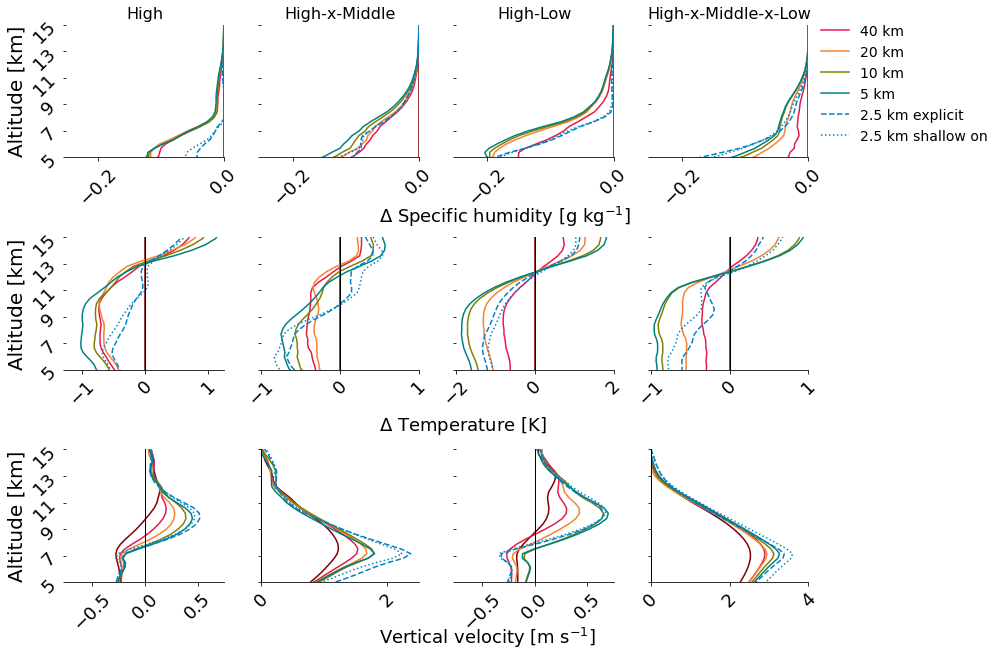

In [37]:
fs = 20
wlim = [ [-0.75, 0.75], [0, 2.5], [-0.75, 0.75], [0, 4] ]
tlim = [ [-1.25, 1.25], [-1, 1], [-2, 2], [-1, 1] ]
qlim = [ [-0.25, 0], [-0.25, 0], [-0.25, 0], [-0.25, 0] ]

fig, ax = plt.subplots(3, 4, figsize=(14, 9), sharey=True)
for j, v in enumerate(var):
    # Read in the reference simulation to make a difference plot
    expids = [key for key in simdict if simdict[key]['res'] == '80km' and \
                                            simdict[key]['conv'] == 1 and \
                                            simdict[key]['mphys'] == 2]
    
    # read variable from all simulations that have the same configuration
    data = []
    for expid in expids:
        ds = xr.open_dataset(ipath + expid + \
                         '_w_temp_qv_cloudclasses_' + \
                         'areamean_timemean_oceanmask_applied_' + \
                         threshold + '.nc')
        data.append(ds)
        del ds
    del expid

    # merge data and get mean over simulations
    ds_ref_mphy2 = xr.concat([x for x in data], 'nsim')
    ds_ref_mphy2 = ds_ref_mphy2.mean('nsim')
    del data, expids
    
    for res in resolutions:
        if res in ['80km', '40km', '20km', '10km', '5km']:
            conv = 1
            lstyle='-'
        elif res == '2km':
            conv = 0
            lstyle = '--'
        elif res == '2km-shcon':
            conv = 2
            lstyle = ':'
            res = '2km'

        # get all expids for simulations with same configuration
        expids = [key for key in simdict if simdict[key]['res'] == res and \
                                            simdict[key]['conv'] == conv and \
                                            simdict[key]['mphys'] == mphys]

        # read variable from all simulations that have the same
        # configuration
        data = []
        for expid in expids:
            ds = xr.open_dataset(ipath + expid + \
                                '_w_temp_qv_cloudclasses_' + \
                                'areamean_timemean_oceanmask_applied_' + \
                                threshold + '.nc')
            data.append(ds)
            del ds
        
        # merge data with same configuration and get mean over simulations
        ds = xr.concat([x for x in data], 'nsim')
        ds = ds.mean('nsim')
        
        # plot cloud cover for different cloud classes
        for i, c in enumerate([0, 3, 5, 6]):
            if res == '2km' and conv == 0:
                lbl = '2.5 km explicit'
            elif res == '2km' and conv == 2:
                lbl = '2.5 km shallow on'
            elif res == '80km':
                lbl = ''
            elif res == '5km':
                lbl = res[:1] + ' km'
            else:
                lbl = res[:2] + ' km'
                
            if v == 'w':
                ax[j, i].plot(ds[v + '_cclass' + str(c+1)]*100., zhalf/1000,
                                    color=colordict[res], linestyle=lstyle, label=lbl)
                ax[j, i].set_xlim( [wlim[i][0], wlim[i][1]] )
                
            elif v == 'temp':
                val = ds[v + '_cclass' + str(c+1)] - ds_ref_mphy2[v + '_cclass' + str(c+1)]
                ax[j, i].plot(ds[v + '_cclass' + str(c+1)] - \
                                  ds_ref_mphy2[v + '_cclass' + str(c+1)], zfull/1000,
                                  color=colordict[res], linestyle=lstyle, label=lbl)
                ax[j, i].set_xlim( [tlim[i][0], tlim[i][1]] )
                
            else:
                ax[j, i].plot((ds[v + '_cclass' + str(c+1)] - \
                                  ds_ref_mphy2[v + '_cclass' + str(c+1)])*1000, zfull/1000,
                                  color=colordict[res], linestyle=lstyle, label=lbl)
                ax[j, i].set_xlim( [qlim[i][0], qlim[i][1]] )
                
            ax[j, i].tick_params(labelsize=fs-2, rotation=45)
            ax[j, i].spines['right'].set_color('none')
            ax[j, i].spines['top'].set_color('none')
            ax[j, i].spines['left'].set_color('none')
            ax[j, i].axvline(0, linewidth=1, color='k')
            ax[j, i].set_ylim(5, 15)
            ax[j, i].set_yticks([5, 7, 9, 11, 13, 15])
            ax[0, i].set_title(cclasses[c], fontsize=fs-4)
    
    ax[j,0].set_ylabel( 'Altitude [km]', fontsize=fs )
    
ax[0,3].legend( frameon=False, fontsize=fs-6, bbox_to_anchor=(1.0,1.1) )
# legend: text for lines
#xloc = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
#for r, res in enumerate(resolutions[:-1]):
#    fig.text(xloc[r], -0.04, resolutions[r], color=colordict[res],
#                ha='left', va='center', rotation='horizontal', fontsize=fs,
#                backgroundcolor='white')

fig.text( 0.38, 0, r'Vertical velocity [m s$^{-1}$]', fontsize=fs-2 )  
fig.text( 0.38, 0.33, r'$\Delta$ Temperature [K]', fontsize=fs-2 )
fig.text( 0.38, 0.65, r'$\Delta$ Specific humidity [g kg$^{-1}$]', fontsize=fs-2 )
fig.tight_layout()    
plt.subplots_adjust(hspace=0.6)

fig.savefig('/groups/sylvia/nawdex-hackathon/figs/w_T_qv_cloudclass.pdf', bbox_inches = 'tight', dpi=600)

# Figure 13: Probability distributions of updraft velocity

In [38]:
path = '/groups/sylvia/nawdex-hackathon/ccf_data/'
ds_list1 = []
for filename in os.listdir(path):
    if filename.endswith("_omega500_pdf.nc"):
        ds_temp = xr.open_dataset(path+filename)
        ds_list1.append(ds_temp)
        ds_temp.close()

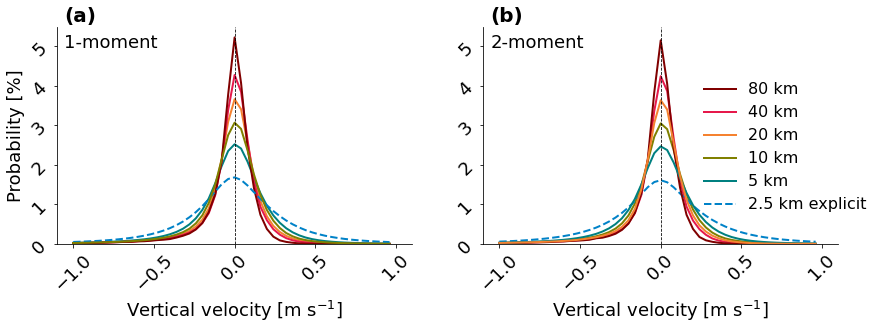

In [39]:
fs = 18
fig = plt.figure( figsize=(14,4) )
pan1 = plt.subplot(1,2,1)
pan2 = plt.subplot(1,2,2)
let = [ '(a)', '(b)' ]
mom = [ '1-moment', '2-moment' ]

for ds in ds_list1:
        
    simname = ds.omega_pdf.attrs['simulation']
    res     = (simdict[simname])['res']
    start   = (simdict[simname])['start']
    conv    = (simdict[simname])['conv' ] 
    mphys   = (simdict[simname])['mphys']
    
    if conv == 0: 
        linestyle='--'
        lbl = '2.5 km explicit'
    if conv == 1 and res != '5km': 
        linestyle='-'
        lbl = res[:2] + ' km'
    if conv == 1 and res == '5km':
        linestyle='-'
        lbl = res[:1] + ' km'
    if conv == 0 and res != '2km':
        continue
    if conv == 1 and res == '2km':
        continue
    if start == '20160922':
        if mphys == 1:
            pan1.plot(ds.bins, ds['omega_pdf'], color=farbe[res[:-2]], ls=linestyle, label=lbl, lw=2)
        if mphys == 2:
            pan2.plot(ds.bins, ds['omega_pdf'], color=farbe[res[:-2]], ls=linestyle, label=lbl, lw=2)

# get legend handles and labels
handles, labels = pan2.get_legend_handles_labels()

# specify order of items in legend
order = [3, 0, 5, 1, 4, 2]
pan2.legend([handles[idx] for idx in order], [labels[idx] for idx in order], bbox_to_anchor=(0.58,0.08),
            frameon=False, fontsize=fs-2 )
pan1.set_ylabel( 'Probability [%]', fontsize=fs )
for j,p in enumerate([pan1, pan2]):
    p.tick_params( labelsize=fs, rotation=45 )
    p.spines['right'].set_color('none')
    p.spines['top'].set_color('none')
    p.set_xlabel( r'Vertical velocity [m s$^{-1}$]', fontsize=fs )
    p.set_xlim( [-1.1, 1.1] )
    p.set_ylim( [0, 5.5] )
    p.plot( [0,0], [0,5.5], color='k', lw=0.8, ls='--' )
    p.text( 0.02, 1.02, let[j], weight='bold', fontsize=fs+2, transform=p.transAxes )
    p.text( 0.02, 0.9, mom[j], fontsize=fs, transform=p.transAxes )
    
plt.show()
fig.savefig( '/groups/sylvia/nawdex-hackathon/figs/vertical-velocity-distributions.pdf', bbox_inches='tight' )